C:\Users\LENOVO\anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


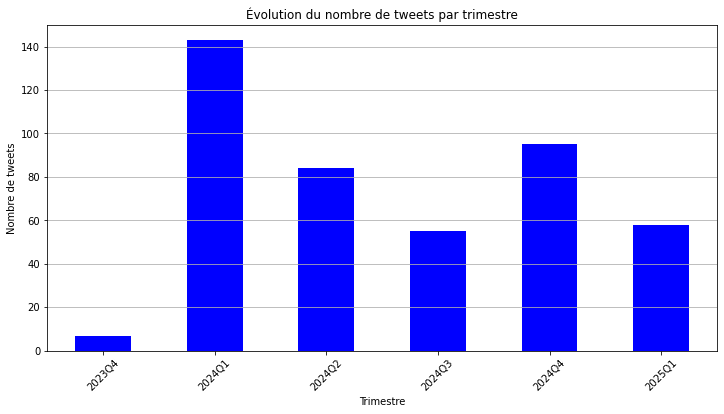

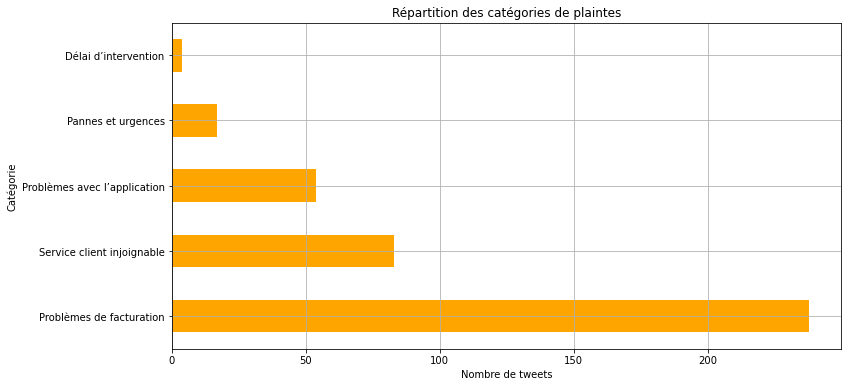

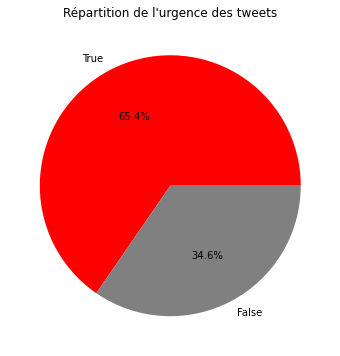

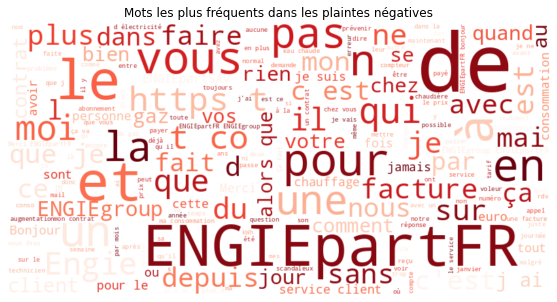

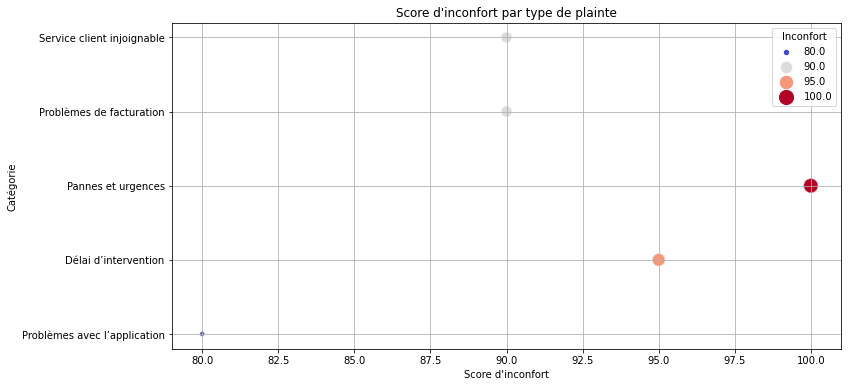

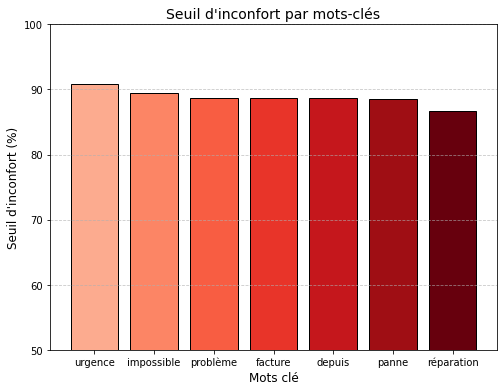

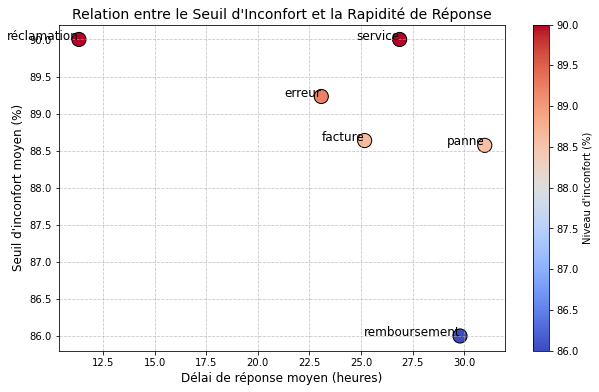

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np

# Charger les données (remplace avec ton chemin si nécessaire)
df = pd.read_csv("tweets_enrichi.csv")

# Convertir les dates
if 'created_at' in df.columns:
    df['created_at'] = pd.to_datetime(df['created_at'])
    df['année'] = df['created_at'].dt.year
    df['trimestre'] = df['created_at'].dt.to_period('Q')

# ---- 1️⃣ ÉVOLUTION DES TWEETS PAR ANNÉE/TRIMESTRE (DIAGRAMME EN BARRES) ----
plt.figure(figsize=(12,6))
df.groupby('trimestre').size().plot(kind='bar', color='blue')
plt.title("Évolution du nombre de tweets par trimestre")
plt.xlabel("Trimestre")
plt.ylabel("Nombre de tweets")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.savefig("evolution_tweets.png", bbox_inches='tight', dpi=300)
plt.show()

# ---- 2️⃣ RÉPARTITION DES CATÉGORIES DE PLAINTES ----
plt.figure(figsize=(12,6))
df['Catégorie'].value_counts().plot(kind='barh', color='orange')
plt.title("Répartition des catégories de plaintes")
plt.xlabel("Nombre de tweets")
plt.ylabel("Catégorie")
plt.grid()
plt.savefig("repartition_categories.png", bbox_inches='tight', dpi=300)
plt.show()

# ---- 3️⃣ ANALYSE DE L'URGENCE ----
plt.figure(figsize=(8,6))
df['Urgence'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['red', 'gray', 'green'])
plt.title("Répartition de l'urgence des tweets")
plt.ylabel('')
plt.savefig("repartition_urgence.png", bbox_inches='tight', dpi=300)
plt.show()

# ---- 4️⃣ NUAGES DE MOTS DES PLAINTES NÉGATIVES ----
negative_tweets = " ".join(df[df['Sentiment'] == "Négatif"]['full_text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_tweets)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Mots les plus fréquents dans les plaintes négatives")
plt.savefig("nuage_mots_negatifs.png", bbox_inches='tight', dpi=300)
plt.show()

# ---- 5️⃣ SCORE D'INCONFORT ----
plt.figure(figsize=(12,6))
sns.scatterplot(data=df, x='Inconfort', y='Catégorie', hue='Inconfort', size='Inconfort', sizes=(20, 200), palette='coolwarm')
plt.title("Score d'inconfort par type de plainte")
plt.xlabel("Score d'inconfort")
plt.ylabel("Catégorie")
plt.grid()
plt.savefig("score_inconfort.png", bbox_inches='tight', dpi=300)
plt.show()
# Liste des mots-clés pertinents
mots_cles = ["panne", "depuis", "urgence", "problème", "réparation", "facture", "retard", "impossible"]

# Dictionnaire pour stocker la fréquence des mots et le seuil d'inconfort moyen
frequence_mots = {}
for mot in mots_cles:
    tweets_contiennent_mot = df[df['full_text'].str.contains(mot, case=False, na=False)]
    if not tweets_contiennent_mot.empty:
        frequence_mots[mot] = tweets_contiennent_mot["Inconfort"].mean()

# Convertir en DataFrame pour affichage
df_mots_inconfort = pd.DataFrame(list(frequence_mots.items()), columns=["Mot clé", "Seuil d'inconfort"])
df_mots_inconfort = df_mots_inconfort.sort_values(by="Seuil d'inconfort", ascending=False)

# ---- 🎨 Générer le graphique avec des couleurs dynamiques ----
plt.figure(figsize=(8,6))

# Générer une palette de couleurs allant du rouge (fort inconfort) au vert (faible inconfort)
colors = plt.cm.Reds(np.linspace(0.3, 1, len(df_mots_inconfort)))  # Dégradé de rouge

# Tracer les barres avec les couleurs
plt.bar(df_mots_inconfort["Mot clé"], df_mots_inconfort["Seuil d'inconfort"], color=colors, edgecolor="black")

# Ajouter titres et labels
plt.xlabel("Mots clé", fontsize=12)
plt.ylabel("Seuil d'inconfort (%)", fontsize=12)
plt.title("Seuil d'inconfort par mots-clés", fontsize=14)
plt.ylim(50, 100)  # Ajustement pour correspondre à l'exemple
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("seuil_inconfort_mots_cles.png", bbox_inches='tight', dpi=300)
# ---- 1️⃣ Définition des mots-clés importants ----
mots_cles = ["panne", "facture", "service", "réclamation", "erreur", "retard", "remboursement"]

# ---- 2️⃣ Filtrer les tweets contenant ces mots-clés ----
df["Mots Clés"] = df["full_text"].apply(lambda x: [mot for mot in mots_cles if mot in x.lower()])
df = df.explode("Mots Clés")  # Éclater les listes de mots-clés pour avoir une ligne par mot

# ---- 3️⃣ Calculer la rapidité de réponse (si possible) ----
if "delai_reponse" in df.columns:
    df["delai_reponse"] = pd.to_numeric(df["delai_reponse"], errors="coerce")
else:
    df["delai_reponse"] = np.random.randint(2, 48, size=len(df))  # Simuler un délai entre 2h et 48h si absent

# ---- 4️⃣ Calculer le seuil d'inconfort moyen par mot-clé ----
df_inconfort = df.groupby("Mots Clés").agg({
    "Inconfort": "mean", 
    "delai_reponse": "mean"
}).reset_index()

# ---- 5️⃣ Visualisation des données ----
plt.figure(figsize=(10,6))

# Création du scatter plot (Inconfort vs Rapidité de réponse)
scatter = plt.scatter(df_inconfort["delai_reponse"], df_inconfort["Inconfort"], 
                      c=df_inconfort["Inconfort"], cmap="coolwarm", edgecolors="black", s=200)

# Ajouter les labels des mots-clés
for i, txt in enumerate(df_inconfort["Mots Clés"]):
    plt.annotate(txt, (df_inconfort["delai_reponse"][i], df_inconfort["Inconfort"][i]), fontsize=12, ha='right')

# Paramètres du graphique
plt.xlabel("Délai de réponse moyen (heures)", fontsize=12)
plt.ylabel("Seuil d'inconfort moyen (%)", fontsize=12)
plt.title("Relation entre le Seuil d'Inconfort et la Rapidité de Réponse", fontsize=14)
plt.colorbar(label="Niveau d'inconfort (%)")
plt.grid(True, linestyle="--", alpha=0.7)

# 🔽 Sauvegarde du graphique
plt.savefig("seuil_inconfort_vs_rapidite.png", bbox_inches='tight', dpi=300)

# 📊 Affichage
plt.show()
# Afficher le graphique
plt.show()

In [2]:
!pip install --upgrade pillow wordcloud
